# **Open Data Examples** | Get American Community Survey Data by Ward
This notebook will walk you through the following:
* Extract American Community Survey (ACS) data from the City of Cleveland Open Data Portal using the `arcgis` API.
* Apportion the American Community Survey data to Cleveland Wards using `cledatatoolkit`.
* Calcuate custom proportions and margins of error for the apportioned data.
* Visualize the data on a map using `geopandas`.

For this specific example, we will be focusing on *disability* related data. More specifically, we will calculate the following:
* Number of people with disabilities by ward.
* Percent of each ward's population with a disability.
* Margins of error for both the count and percentages of people with a disability.

In [24]:
import numpy as np
import geopandas as gpd

from arcgis import GIS

from cledatatoolkit.spatial import apportion, build_aggregator
from cledatatoolkit.census import calc_moe

## Extract ACS Data from the Open Data Portal
First, we want to establish a connection to the Open Data Portal using the `GIS` function from the `arcgis` API for Python.

In [25]:
#Connect to the City of Cleveland ArcGIS Online service.
gis = GIS("https://clevelandgis.maps.arcgis.com/")

Next, we will load in the current ACS data for the City of Cleveland using the `GIS.content.get` function. Then we will convert the `Disability Status` layer from the `item` to `GeoDataFrame`.

<Axes: >

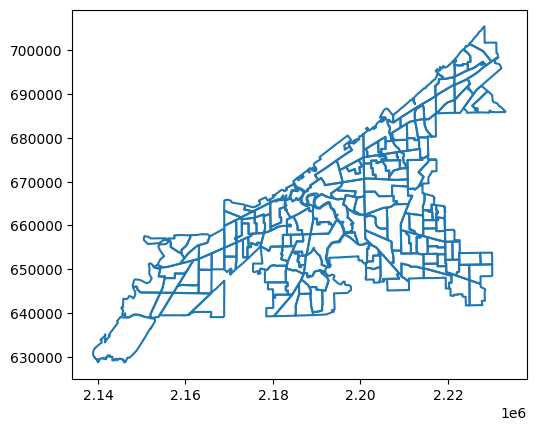

In [26]:
#First, let's get the ID of the ACS data in the Open Data Portal:
acs_id = '89c639f534684dbaab9218d2227580ba'
#Then fetch the content from ArcGIS Online
item = gis.content.get(acs_id)
#Get the layer by searching each layer's name. If the name matches "Disability Status", include it in the list. 
#Then extract the first element of that list
ds_layer = [a for a in item.layers if a.properties.name == "Disability Status"][0]
#Convert the layer to a spatially enabled dataframe
ds_sdf = ds_layer.query().sdf

#Extract the Coordinate Reference System (CRS) from the layer service definition
ds_crs = ds_layer.properties.extent.spatialReference.latestWkid
#Now build the geodataframe from the spatially enabled dataframe, we will standardize the coordinate reference system (CRS) to EPSG 3734, Ohio North
ds_gdf = gpd.GeoDataFrame(ds_sdf,geometry=ds_sdf.SHAPE,crs=ds_crs).to_crs(3734)
#Filter the geodataframe for census tracts in Cleveland
ds_gdf = ds_gdf[ds_gdf['PLACENAME'] == 'Cleveland city']
#Display the census tracts
ds_gdf.geometry.boundary.plot()

Now we subset the dataframe for the following fields:
1. `GEOID`: This is the geographic identifier of each Census Tract in the dataset.
2. `NAME`: This is the long form name of the Census Tract.
3. `B18101_calc_numDE`: This field represents the total population with a disability in a Census Tract.
4. `B18101_calc_numDM`: This field is the margin of error of the above estimate.
5. `B18101_001E`: The total civilian noninstitutionalized population-- this serves as the denominator when calculating there percentage of people with a disability.
6. `B18101_001M`: The margin of error of the above estimate.
7. `geometry`: This field contains the actual polygons that are plotted on the map.

How did I know the fields in the above list represented disability estimates and MOEs? I looked at the [service definition](https://services3.arcgis.com/dty2kHktVXHrqO8i/ArcGIS/rest/services/Census%20Data/FeatureServer/13?token=66ulAOka41ncUmGicOt-Fo1VlAE_4uSslM4TPISUrKSKTMju-Mi6aOKDOC--udHq3F9I6SvQuWDohNnilQ6HxX_DitGuUOOJ353epIThELU2xvTtYJkxKuSswCXOyhwSd9ycV8ckoJG5WrFjnKqoLSnm-KGwbyqiIP4U1qAqSrdVTsaWymiV7i8HeuQ5Ob4c4w9t9nNbzsNuY4p0qx_6mLytfdJ13I3Tj6bjmagYh00.) of the layer.

In [27]:
#Subset the dataframe and rename the fields
disability_status = ds_gdf[['GEOID', 'NAME', 'B18101_001E', 'B18101_001M','B18101_calc_numDE', 'B18101_calc_numDM', 'geometry']]\
    .rename(columns={"B18101_001E":"TOTAL_POP","B18101_001M":"TOTAL_POP_M","B18101_calc_numDE":"POP_WITH_DISABILITY","B18101_calc_numDM":"POP_WITH_DISABILITY_M"})

#View the first five rows of the result
disability_status.head()

,GEOID,NAME,TOTAL_POP,TOTAL_POP_M,POP_WITH_DISABILITY,POP_WITH_DISABILITY_M,geometry
0,39035101101,Census Tract 1011.01,1977,431.0,458,142,"MULTIPOLYGON (((2175866.166 661802.020, 217580..."
1,39035101102,Census Tract 1011.02,4298,660.0,608,193,"MULTIPOLYGON (((2173732.914 664642.902, 217355..."
2,39035101300,Census Tract 1013,1519,213.0,347,100,"MULTIPOLYGON (((2172701.481 661838.899, 217236..."
3,39035101400,Census Tract 1014,1711,322.0,469,127,"MULTIPOLYGON (((2171375.440 657036.740, 217137..."
4,39035101501,Census Tract 1015.01,2013,286.0,459,131,"MULTIPOLYGON (((2172883.465 661482.268, 217288..."


## Extract Ward Boundaries from the Open Data Portal
Now that we've extracted the ACS data, we will need the ward boundaries in order to merge the disability prevalence information. This process is very similar to the above section. We will use the `gis.content.get` function to extract the ward boundaries item, then we will convert the item's `layer` to a `GeoDataFrame`.

<Axes: >

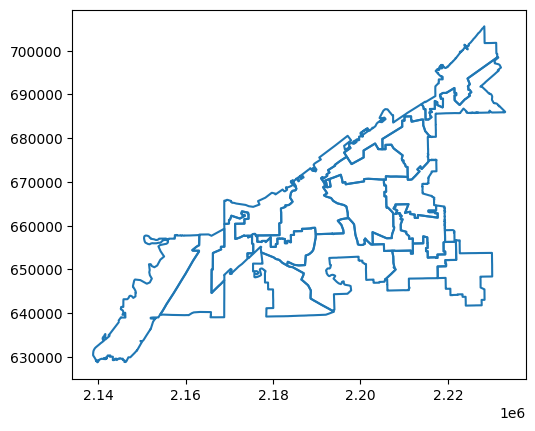

In [28]:
#First, let's get the ID of the Ward boundaries from the Open Data Portal:
ward_id = 'af288688b25345e8b7d5dcf750f21fc1'
#Then fetch the content from ArcGIS Online
item = gis.content.get(ward_id)

#Now extract the layer, and convert it to GeoDataFrame
w_layer = item.layers[0]
w_sdf = w_layer.query().sdf 
#Extract the Coordinate Reference System (CRS) from the layer service definition
w_crs = w_layer.properties.extent.spatialReference.latestWkid
w_gdf = gpd.GeoDataFrame(w_sdf,geometry=w_sdf.SHAPE,crs=w_crs)
#Subset for relevant information
wards = w_gdf[['WARD','NAME','COUNCILMEMBER','geometry']].rename(columns={"WARD":"WARD_NO","NAME":"WARD_NAME"})

#Plot the results
wards.geometry.boundary.plot()

## Apportion ACS Data to Wards
The aim of this section is to calculate the number of people with a disability per ward and the margin of error for that estimate. Importantly, census tracts do not align perfectly with the ward boundary edges, so we will have to determine a strategy for resolving these overlapping edges. There are a number of ways to do this, but the method we use we call `largest overlap`. The `largest overlap` method does the following:

1. Overlay the census tracts on the wards.
2. If a census tract falls across two different wards, calculate the area of each census tract for each ward.
    * For example, if a Census Tract falls on the boundary of Ward 16 and 17, we calculate that 60% of its area is in Ward 16, and the remaining 40% is in Ward 17.
3. Whichever ward contains a majority of the Census Tract's area, assign that Census Tract's data to said Ward.
    * Continuing the example above, we would assign the Census Tract's data to Ward 16.

Once this process is complete, we can aggregate all the data across census tracts within each Ward. For example, if Ward 16 is assigned 8 Census Tracts from the `largest overlap` process, and each ward has a population of 1,000, we determine Ward 16's population to be 8,000.

### The `calc_moe` function
Margins of Error are aggregated in a different way than regular estimates. Instead of simply summing up all the values for each Census Tract, we use the following formula:
<p align="center"><img src=resources/moe_sum.PNG></img></p>

Where $MOE(\hat{x}_{1})$ represents the Margin of Error for estimate 1, $MOE(\hat{x}_{2})$ represents the Margin of Error for estimate 2, and so on.

To learn more about how Margins of Error are calculated for derived estimates, please checkout [this](https://www.census.gov/content/dam/Census/library/publications/2018/acs/acs_general_handbook_2018_ch08.pdf) article from the US Census Bureau. There are different ways to calculate the Margin of Error depending on if you are summing, averaging, or taking a proportion of your estimates.

The `calc_moe` function will calculate the Margins of Error for estimates based on some aggregation strategy. It takes the following parameters:
1. `array`: This is a list, or lists of values that are required to calculate a margin of error for a derived estimate. For example, using the above formula, the array we would pass through would look like this: [$\hat{x}_{1}$,$\hat{x}_{2}$...$\hat{x}_{n}$]
2. `how`: This is the aggregation strategy of the estimates. It takes either `sum`, `mean`, or `proportion` and will calculate the margin of error accordingly.

The function will return the value of the margin of error for all estimates within the passed arrays.


### The `apportion` function
The entire aggregation process listed above is wrapped into the function `apportion` from the `cledatatoolkit` package. The `apportion` function takes the following arguments:
1. `left`: The GeoDataFrame containing the data of interest. In this case, this will be our `ds` DataFrame from the ACS data.
2. `right`: The GeoDataFrame containing the geography to which you will apportion the data from `left`. This is the `w` DataFrame containing the ward information.
3. `group_key`: The ID column of the `right` GeoDataFrame. This will be the `WARD` column from the `w` DataFrame.
4. `target_key`: The ID column of the `left` GeoDataFrame. This will be the `GEOID` column from the `ds` DataFrame.
5. `aggregator`: A python dictionary assigning the aggregation strategy to relevant columns from the `left` GeoDataFrame. In our case, the `aggregator` should look something like this:

```
aggregator = {
    TOTAL_POP: 'sum',
    TOTAL_POP_M: lambda x: calc_moe(x, 'sum'),
    POP_WITH_DISABLITY: 'sum',
    POP_WITH_DISABILITY_M: lambda x: calc_moe(x,'sum')
}
```

This function will return a GeoDataFrame with the apportioned estimates. In this case, we will receive a GeoDataFrame with one row for each ward, and the sum of `POP_WITH_DISABILITY`, and the margin of error for that sum, listed under the `POP_WITH_DISABILITY_M` column. The same will apply for the `TOTAL_POP` and `TOTAL_POP_M` columns.

### The `build_aggregator` function
The above `aggregator` dictionary can be constructed using `build_aggregator`. The function will iterate through every column in the inputted DataFrame. If the column contains numeric data, it is added to the returned dictionary. Furthermore, if a column name ends with `_M` (the default naming mechanism for Margins of Error in ACS data), the function will assign the appropriate `calc_moe` implementation. Using this function is ideal for apportioning larger ACS datasets. The function takes the following parameters:
1. `df`: The DataFrame for which you want to build the aggregator. In our case we will use the `ds` DataFrame.
2. `exclude`: A list of columns to exclude from the aggregator build process.
3. `default`: The default aggregation strategy you are using. In this case we will use `sum`.

First we will build the aggregator for our Disability Status data.

In [29]:
aggregator = build_aggregator(disability_status,exclude=None)
print(aggregator)

{'TOTAL_POP': 'sum', 'TOTAL_POP_M': <function build_aggregator.<locals>.<lambda> at 0x000001744E3D4180>, 'POP_WITH_DISABILITY': 'sum', 'POP_WITH_DISABILITY_M': <function build_aggregator.<locals>.<lambda> at 0x000001740680E700>}


Now we will apportion the ACS data to wards using the `apportion` function.

In [30]:
#Apportion the census data by ward
wards_ds = apportion(left=disability_status, right=wards, group_key="WARD_NO", target_key="GEOID", aggregator=aggregator)
#Show the data sorted by number of people with a disability:
wards_ds.sort_values('TOTAL_POP',axis=0,ascending=False).drop('geometry',axis=1)

,TOTAL_POP,TOTAL_POP_M,POP_WITH_DISABILITY,POP_WITH_DISABILITY_M,WARD_NO,WARD_NAME,COUNCILMEMBER
10,27952,1310.0,4169,468,3,Ward 3,Kerry McCormack
3,26372,1713.0,4769,556,13,Ward 13,Kris Harsh
7,24994,1465.0,3962,526,17,Ward 17,Charles J Slife
2,24648,1535.0,5454,612,12,Ward 12,Rebecca Maurer
5,24294,1366.0,5291,518,15,Ward 15,Jenny Spencer
0,23257,1531.0,4682,507,10,Ward 10,Anthony T Hairston
6,22273,1409.0,4298,484,16,Ward 16,Brian Kazy
13,20268,1272.0,4805,565,7,Ward 7,Stephanie D Howse
9,20265,1640.0,3844,461,2,Ward 2,Kevin L Bishop
12,20094,1681.0,4683,613,5,Ward 5,Richard A Starr


## Calculate Proportions
Now that we have the number of people with a disability and the corresponding margin of error for each ward in the city, we will now calculate the percentage of people with a disability. In this section we will calculate four new fields:
1. `PROP_WITH_DISABILITY`: This is the proportion of the population within a ward that has a disability.
2. `PROP_WITH_DISABILITY_M`: This is the margin of error for the proportion of the population with a disability.
3. `PERCENT_WITH_DISABILITY`: `PROP_WITH_DISABILITY` * 100
4. `PERCENT_WITH_DISABILITY_M`: `PROP_WITH_DISABILITY_M` * 100

Calculating the first of these four variables is easy:

In [31]:
wards_ds.loc[:,'PROP_WITH_DISABILITY'] = wards_ds['POP_WITH_DISABILITY'] / wards_ds['TOTAL_POP']

Next, we will calculate the margin of error for the above proportion. The [ACS](https://www.census.gov/content/dam/Census/library/publications/2018/acs/acs_general_handbook_2018_ch08.pdf) calculates margins of error for derived proportions using the following formula: 
<p align="center"><img src=resources/moe_prop.PNG></img></p>

Where $\hat{P}$ represents the calculated proportion (`PROP_WITH_DISABILITY`), $\hat{X}$ the numerator of the proportion (`POP_WITH_DISABILITY`), and $\hat{Y}$ the denominator (`TOTAL_POP`). $MOE()$ represents the margin of error for the associated estimate.

`calc_moe` can calculate the margin of error for proportions by simply setting the `how` argument to `proportion`. However, the `arrays` argument needs to be formatted as 2D array, consisting of the following:
1. The denominators of the proportion ($\hat{Y}$ from the above formula).
2. The proportions themselves ($\hat{P}$).
3. The margins of error of the numerator ($MOE(\hat{X})$).
4. The margins of error of the denominator ($MOE(\hat{Y})$).

In [32]:
#Arrange the arrays to match the required structure for calc_moe
arrays = [wards_ds['TOTAL_POP'], wards_ds['PROP_WITH_DISABILITY'], wards_ds['POP_WITH_DISABILITY_M'], wards_ds['TOTAL_POP_M']]
#Calculate the MOE
wards_ds.loc[:,'PROP_WITH_DISABILITY_M'] = calc_moe(arrays,how='proportion')

Lastly, we represent the columns from above as percentages.

In [33]:
wards_ds.loc[:,'PERCENT_WITH_DISABILITY'] = np.round(100*wards_ds['PROP_WITH_DISABILITY'],2)
wards_ds.loc[:,'PERCENT_WITH_DISABILITY_M'] = np.round(100*wards_ds['PROP_WITH_DISABILITY_M'],2)

#Reorder columns for displaying
cols = ['WARD_NO','PERCENT_WITH_DISABILITY','PERCENT_WITH_DISABILITY_M','POP_WITH_DISABILITY','POP_WITH_DISABILITY_M','TOTAL_POP','TOTAL_POP_M','WARD_NAME','COUNCILMEMBER']
wards_ds[cols].sort_values('PERCENT_WITH_DISABILITY',axis=0,ascending=False)

,WARD_NO,PERCENT_WITH_DISABILITY,PERCENT_WITH_DISABILITY_M,POP_WITH_DISABILITY,POP_WITH_DISABILITY_M,TOTAL_POP,TOTAL_POP_M,WARD_NAME,COUNCILMEMBER
13,7,23.71,2.36,4805,565,20268,1272.0,Ward 7,Stephanie D Howse
12,5,23.31,2.35,4683,613,20094,1681.0,Ward 5,Richard A Starr
4,14,22.92,2.19,4360,503,19019,1236.0,Ward 14,Jasmin Santana
14,6,22.6,2.58,4334,571,19173,1268.0,Ward 6,Blaine A Griffin
2,12,22.13,2.07,5454,612,24648,1535.0,Ward 12,Rebecca Maurer
5,15,21.78,1.75,5291,518,24294,1366.0,Ward 15,Jenny Spencer
15,8,21.45,2.8,4231,630,19721,1416.0,Ward 8,Michael D Polensek
8,1,20.8,2.59,3654,532,17565,1325.0,Ward 1,Joseph T Jones
0,10,20.13,1.73,4682,507,23257,1531.0,Ward 10,Anthony T Hairston
11,4,20.07,2.03,3212,441,16003,1489.0,Ward 4,Deborah A Gray


## Map Results with `geopandas`
We will use the apportioned `wards_ds` DataFrame from above to map the percent of individuals with a disability by ward. To do this, we will use the `explore()` method on the GeoDataFrame. Please note that to visualize the map, you will need the following libraries in addition to `geopandas`:
1. `folium`
2. `matplotlib`
3. `mapclassify`

The below code will generate an interactive HTML map, feel free to play around with the styling parameters to your liking. You can learn more about the `explore()` method [here]('https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.explore.html).

In [34]:
#Set the tooltip specification to show these fields.
tooltip = ["WARD_NAME","PERCENT_WITH_DISABILITY","PERCENT_WITH_DISABILITY_M"]
#Set the opacity of the polygons to 75%
style = {"fillOpacity":0.75}
#Set the legend label to 
legend = {"caption":"PERCENT WITH DISABILITY", "colorbar":False}

wards_ds.explore("PERCENT_WITH_DISABILITY",cmap="Blues", scheme='NaturalBreaks', tiles="CartoDB dark_matter", tooltip=tooltip, style_kwds = style, legend_kwds = legend)